In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
!nvidia-smi

Sun May 26 08:48:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Directories
data_dir = '/content/drive/MyDrive/data'
data_dir

'/content/drive/MyDrive/data'

In [7]:
class_names = ['battery', 'glass', 'metal', 'normal plastic', 'paper', 'paper container', 'plastic bottle']
class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}

In [8]:
config = {
    'train_ratio': 0.8,
    'valid_ratio': 0.1,
    'test_ratio': 0.1,
    'batch_size': 64,
    'num_epochs': 30,
}

In [9]:
# Data transforms
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = datasets.ImageFolder(data_dir, data_transforms)
full_dataset

Dataset ImageFolder
    Number of datapoints: 5250
    Root location: /content/drive/MyDrive/data
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from torch.utils.data import DataLoader, Subset

# Assuming full_dataset is a torchvision dataset or similar
targets = np.array(full_dataset.targets)  # Extract the target labels

# Define the split ratios
train_ratio, val_ratio = config['train_ratio'], config['valid_ratio']
test_ratio = 1 - train_ratio - val_ratio

# First stratified split to get training set and temporary set (validation + test)
sss_train = StratifiedShuffleSplit(n_splits=1, test_size=1 - train_ratio, random_state=42)
train_idx, temp_idx = next(sss_train.split(np.zeros(len(targets)), targets))

# Extract the targets for the temporary set
temp_targets = targets[temp_idx]

# Second stratified split to split the temporary set into validation and test sets
sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio/(val_ratio + test_ratio), random_state=620)
val_idx, test_idx = next(sss_val_test.split(np.zeros(len(temp_targets)), temp_targets))

# Map the indices back to the original dataset
val_idx = temp_idx[val_idx]
test_idx = temp_idx[test_idx]

# Create the Subsets
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2)

# Dataloaders and dataset sizes
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Class names
class_names = full_dataset.classes
class_names

['battery',
 'glass',
 'metal',
 'normal plastic',
 'paper',
 'paper container',
 'plastic bottle']

In [11]:
import torch
import torch.nn as nn
import torchvision.models as models

class SimpleResNetVGG16(nn.Module):
    def __init__(self, num_classes=1000):
        super(SimpleResNetVGG16, self).__init__()

        # ResNet 特徵提取部分
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()

        # VGG16 特徵提取部分
        self.vgg16_features = nn.Sequential(*list(models.vgg16(pretrained=True).features.children())[:-1])

        # 新的分類器
        self.classifier = nn.Sequential(
            nn.Linear(512 + 2048 * 7 * 7, 128),  # 將 ResNet 和 VGG16 的特徵拼接起來
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        resnet_features = self.resnet(x)
        vgg16_features = self.vgg16_features(x)
        vgg16_features = vgg16_features.view(vgg16_features.size(0), -1)  # 將 VGG16 的特徵展平
        combined_features = torch.cat((resnet_features, vgg16_features), dim=1)  # 將 ResNet 和 VGG16 的特徵拼接起來
        output = self.classifier(combined_features)
        return output

# 初始化模型
model = SimpleResNetVGG16(num_classes=len(class_names))
model = model.to(device)

# 打印模型結構
print(model)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
 

SimpleResNetVGG16(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [12]:
torch.cuda.empty_cache()

In [13]:
print(torch.cuda.memory_summary())

# 获取指定 CUDA 设备的内存摘要信息
device_index = 0  # 指定 CUDA 设备的索引
print(torch.cuda.memory_summary(device=device_index))

# 获取当前 CUDA 设备的详细内存信息
print(torch.cuda.memory_allocated())

# 获取指定 CUDA 设备的详细内存信息
device_index = 0  # 指定 CUDA 设备的索引
print(torch.cuda.memory_allocated(device=device_index))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 153291 KiB | 153291 KiB | 153291 KiB |      0 B   |
|       from large pool | 148864 KiB | 148864 KiB | 148864 KiB |      0 B   |
|       from small pool |   4427 KiB |   4427 KiB |   4427 KiB |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         | 153291 KiB | 153291 KiB | 153291 KiB |      0 B   |
|       from large pool | 148864 KiB | 148864 KiB | 148864 KiB |

In [14]:
def train_model(model, criterion, optimizer, num_epochs=25):
    best_model_wts = model.state_dict()
    best_val_acc = 0.0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        # print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase} Epoch {epoch}/{num_epochs - 1}', leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += labels.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects.double() / total_samples

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.cpu().item())  # Ensure it's on CPU and convert to item
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.cpu().item())  # Ensure it's on CPU and convert to item
                if epoch_acc > best_val_acc:
                    best_val_acc = epoch_acc
                    best_model_wts = model.state_dict()

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    print(f'Best val Acc: {best_val_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accs, val_accs

# Train model
model, train_losses, val_losses, train_accs, val_accs = train_model(model, criterion, optimizer, num_epochs=config['num_epochs'])

Epoch 0/29


train Loss: 1.0678 Acc: 0.6243


val Loss: 0.5664 Acc: 0.8057
Epoch 1/29


train Loss: 0.5360 Acc: 0.8143


val Loss: 0.4514 Acc: 0.8152
Epoch 2/29


train Loss: 0.4536 Acc: 0.8457


val Loss: 0.3813 Acc: 0.8610
Epoch 3/29


train Loss: 0.3709 Acc: 0.8771


val Loss: 0.3006 Acc: 0.8895
Epoch 4/29


train Loss: 0.3439 Acc: 0.8836


val Loss: 0.3366 Acc: 0.8971
Epoch 5/29


train Loss: 0.3032 Acc: 0.8943


val Loss: 0.3830 Acc: 0.8724
Epoch 6/29


train Loss: 0.2898 Acc: 0.9019


val Loss: 0.3070 Acc: 0.8914
Epoch 7/29


train Loss: 0.2714 Acc: 0.9069


val Loss: 0.2957 Acc: 0.9181
Epoch 8/29


train Loss: 0.2472 Acc: 0.9155


val Loss: 0.2783 Acc: 0.8952
Epoch 9/29


train Loss: 0.2313 Acc: 0.9195


val Loss: 0.2278 Acc: 0.9238
Epoch 10/29


train Loss: 0.2191 Acc: 0.9240


val Loss: 0.2490 Acc: 0.9124
Epoch 11/29


train Loss: 0.1944 Acc: 0.9360


val Loss: 0.2433 Acc: 0.9200
Epoch 12/29


train Loss: 0.2047 Acc: 0.9343


val Loss: 0.2816 Acc: 0.9143
Epoch 13/29


train Loss: 0.1829 Acc: 0.9414


val Loss: 0.2696 Acc: 0.9048
Epoch 14/29


train Loss: 0.1741 Acc: 0.9424


val Loss: 0.2310 Acc: 0.9257
Epoch 15/29


train Loss: 0.1754 Acc: 0.9386


val Loss: 0.1996 Acc: 0.9314
Epoch 16/29


train Loss: 0.1713 Acc: 0.9436


val Loss: 0.2473 Acc: 0.9181
Epoch 17/29


train Loss: 0.1551 Acc: 0.9455


val Loss: 0.2482 Acc: 0.9162
Epoch 18/29


train Loss: 0.1483 Acc: 0.9474


val Loss: 0.2793 Acc: 0.9143
Epoch 19/29


train Loss: 0.1685 Acc: 0.9436


val Loss: 0.2702 Acc: 0.9181
Epoch 20/29


train Loss: 0.1635 Acc: 0.9419


val Loss: 0.2377 Acc: 0.9371
Epoch 21/29


train Loss: 0.1493 Acc: 0.9519


val Loss: 0.2321 Acc: 0.9200
Epoch 22/29


train Loss: 0.1551 Acc: 0.9476


val Loss: 0.2394 Acc: 0.9257
Epoch 23/29


train Loss: 0.1446 Acc: 0.9555


val Loss: 0.2069 Acc: 0.9295
Epoch 24/29


train Loss: 0.1113 Acc: 0.9621


val Loss: 0.2823 Acc: 0.9048
Epoch 25/29


train Loss: 0.1568 Acc: 0.9462


val Loss: 0.2289 Acc: 0.9257
Epoch 26/29


train Loss: 0.1408 Acc: 0.9526


val Loss: 0.1893 Acc: 0.9429
Epoch 27/29


train Loss: 0.1232 Acc: 0.9583


val Loss: 0.2308 Acc: 0.9238
Epoch 28/29


train Loss: 0.1202 Acc: 0.9602


val Loss: 0.2090 Acc: 0.9371
Epoch 29/29


train Loss: 0.1248 Acc: 0.9567


val Loss: 0.2458 Acc: 0.9238
Best val Acc: 0.9429


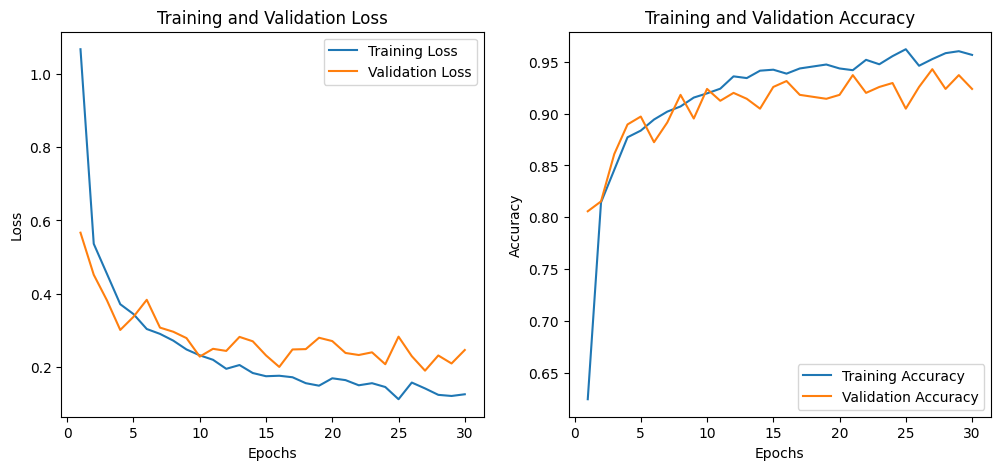

In [15]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Training Accuracy')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

Test Loss: 0.2338 Acc: 0.9238


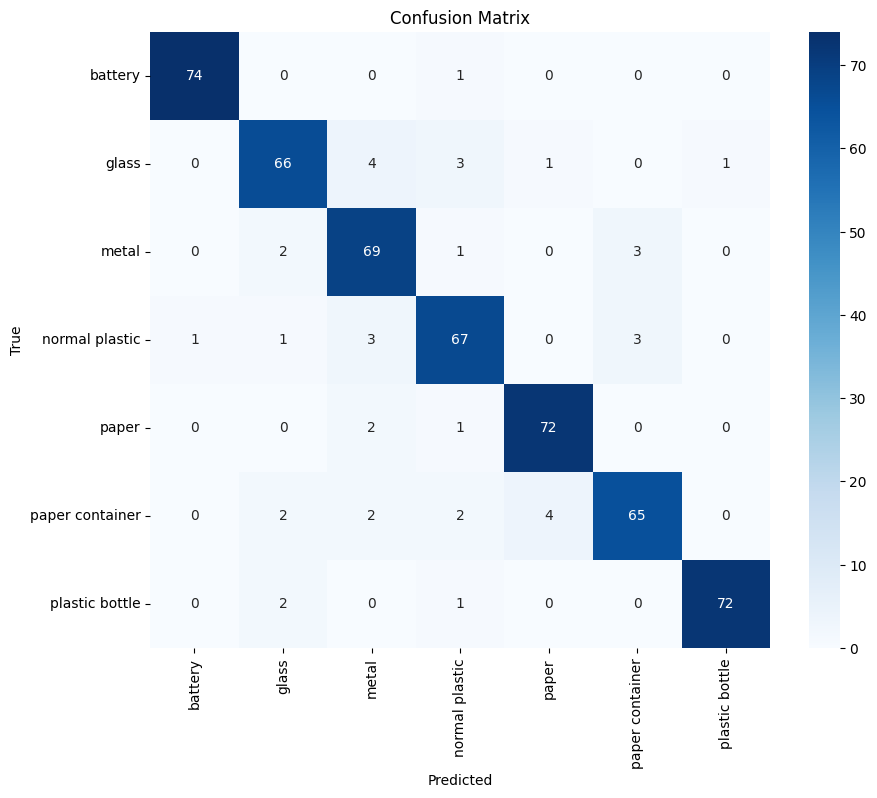


Classification Report:
                 precision    recall  f1-score   support

        battery       0.99      0.99      0.99        75
          glass       0.90      0.88      0.89        75
          metal       0.86      0.92      0.89        75
 normal plastic       0.88      0.89      0.89        75
          paper       0.94      0.96      0.95        75
paper container       0.92      0.87      0.89        75
 plastic bottle       0.99      0.96      0.97        75

       accuracy                           0.92       525
      macro avg       0.92      0.92      0.92       525
   weighted avg       0.92      0.92      0.92       525

Weighted F1 Score: 0.9239
Macro-average F1 Score: 0.9239
Micro-average F1 Score: 0.9238


In [16]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns

# Evaluate model on the test set
def evaluate_model(model, dataloader):
    model.eval()
    running_corrects = 0
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating', leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    loss = running_loss / len(dataloader.dataset)
    acc = running_corrects.double() / len(dataloader.dataset)

    print(f'Test Loss: {loss:.4f} Acc: {acc:.4f}')

    return all_labels, all_preds

# Evaluate on the test set
all_labels, all_preds = evaluate_model(model, dataloaders['test'])

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(all_labels, all_preds, target_names=class_names)
print('\nClassification Report:')
print(class_report)

# F1 Score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'Weighted F1 Score: {f1:.4f}')

# Macro- and Micro-average F1 Scores
macro_f1 = f1_score(all_labels, all_preds, average='macro')
micro_f1 = f1_score(all_labels, all_preds, average='micro')
print(f'Macro-average F1 Score: {macro_f1:.4f}')
print(f'Micro-average F1 Score: {micro_f1:.4f}')

In [22]:
# Save model
torch.save(model.state_dict(), '/content/drive/MyDrive/ResVgg16.ckpt')